In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
df = pd.read_pickle("data.pkl")

print(df.shape)
df.head()


(416809, 2)


,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


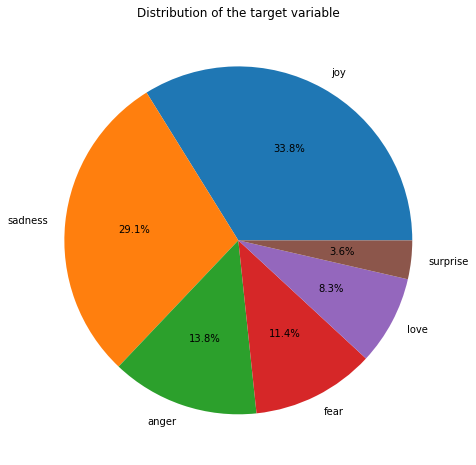

In [4]:
# Count the number of each class
class_counts = df['emotions'].value_counts()

# Create a pie chart
plt.figure(figsize=(8,8), facecolor='white')
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
plt.title('Distribution of the target variable')
plt.show()

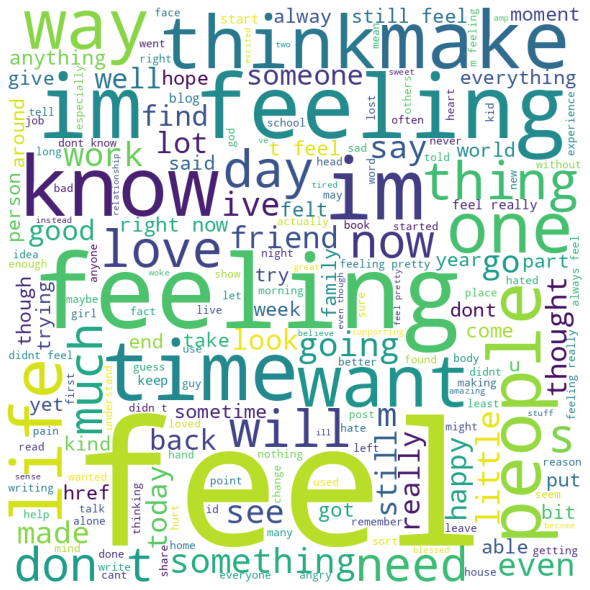

In [5]:
# Create a word cloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(' '.join(df['text']))

# Plot the word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

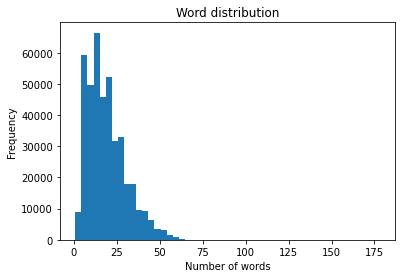

In [6]:
# Word count distribution

word_distribution = df['text'].apply(lambda x: len(x.split()))
plt.hist(word_distribution, bins=50)
plt.title('Word distribution')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()

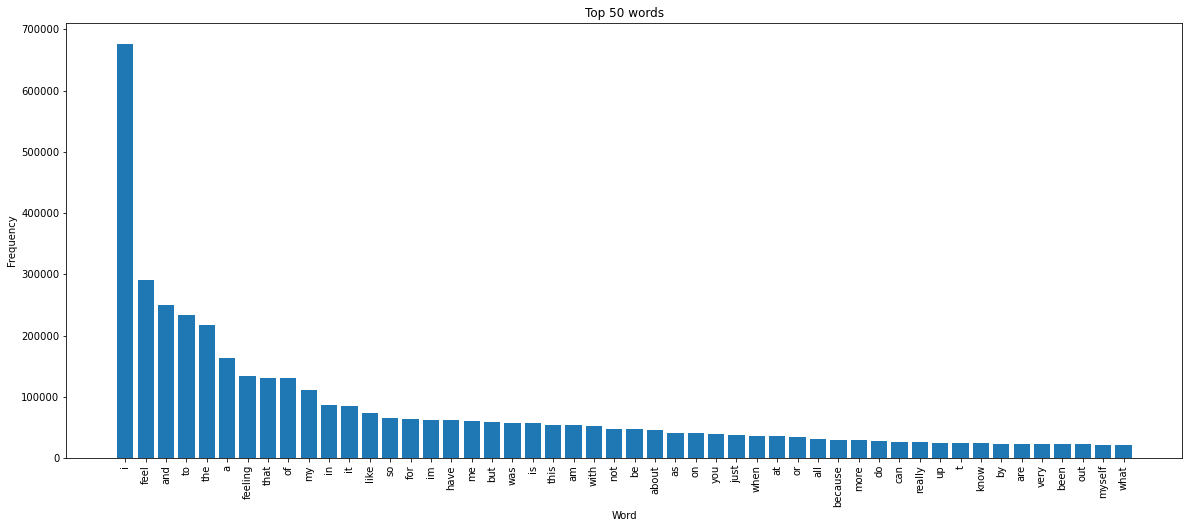

Number of unique words: 75302


In [7]:
# Number of different words and their frequency

# Create a list of all the words
all_words = ' '.join(df['text']).split()

# Count the frequency of each word
word_freq = Counter(all_words)

# Create a dataframe
word_freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency'])

# Sort the dataframe
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

# Plot the frequency of the top words
plt.figure(figsize=(20,8))
plt.bar(word_freq_df['word'][:50], word_freq_df['frequency'][:50])
plt.title('Top 50 words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


# Count the number of unique words
unique_words = len(set(all_words))
print(f'Number of unique words: {unique_words}')

emotions
anger       28441
fear        24539
joy         47342
love        24417
sadness     38615
surprise    14645
Name: text, dtype: int64


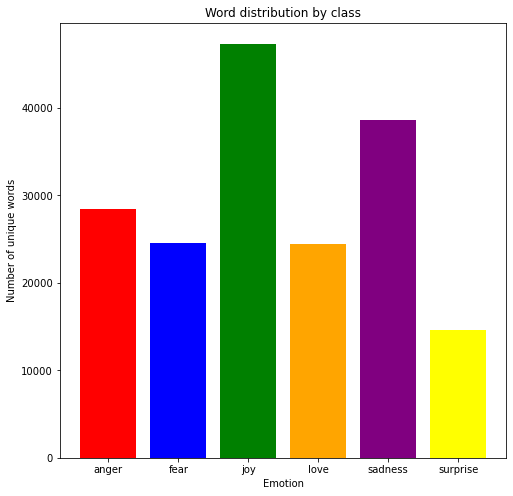

In [19]:
# Word distribution by class
word_distribution_by_class = df.groupby('emotions')['text'].apply(lambda x: len(set(' '.join(x).split())))

print(word_distribution_by_class)
""" emotions
anger       28441
fear        24539
joy         47342
love        24417
sadness     38615
surprise    14645
Name: text, dtype: int64 """


# Word distribution by class
word_distribution_by_class = df.groupby('emotions')['text'].apply(lambda x: len(set(' '.join(x).split())))

# Define a color palette
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']

# Plot the word distribution by class
plt.figure(figsize=(8,8), facecolor='white')
plt.bar(word_distribution_by_class.index, word_distribution_by_class.values, color=colors)
plt.title('Word distribution by class')
plt.xlabel('Emotion')
plt.ylabel('Number of unique words')
plt.show()

In [31]:
# Word (TF-IDF) distribution

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Iterate over each document and update the vectorizer
for doc in df['text']:
    tfidf_vectorizer.fit([doc])

# Transform the entire text data
tfidf_matrix = tfidf_vectorizer.transform(df['text'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print(tfidf_df)